In [1]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv, GraphConv, TransformerConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn import BatchNorm, LayerNorm
import math
from torch_geometric.data import Data, DataLoader
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.explain import Explainer, GNNExplainer

c:\Users\LENOVO\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)
province_order = adj.columns.tolist()
for i, province in enumerate(province_order):
    province_order[i] = province.upper()

print(province_order)

['SULAWESI TENGAH', 'SULAWESI BARAT', 'SULAWESI SELATAN', 'PAPUA BARAT', 'GORONTALO', 'RIAU', 'DAERAH ISTIMEWA YOGYAKARTA', 'SUMATERA BARAT', 'DKI JAKARTA', 'MALUKU', 'BENGKULU', 'LAMPUNG', 'PAPUA', 'KEPULAUAN RIAU', 'NUSA TENGGARA BARAT', 'JAMBI', 'BALI', 'JAWA TIMUR', 'SUMATERA UTARA', 'SULAWESI TENGGARA', 'NUSA TENGGARA TIMUR', 'KALIMANTAN SELATAN', 'ACEH', 'KALIMANTAN TENGAH', 'KEPULAUAN BANGKA BELITUNG', 'SUMATERA SELATAN', 'BANTEN', 'SULAWESI UTARA', 'KALIMANTAN UTARA', 'KALIMANTAN TIMUR', 'JAWA TENGAH', 'MALUKU UTARA', 'KALIMANTAN BARAT', 'JAWA BARAT']


In [3]:
df = pd.read_excel('Sorted.xlsx')

years = df['Tahun'].unique()

similarity_matrices = {}

for year in years:
    df_year = df[df['Tahun'] == year].copy()

    df_year.set_index('Provinsi', inplace=True)

    input_feature = df_year.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Tahun', 'Stunting'])

    scaler = MinMaxScaler()

    feature_scaled = scaler.fit_transform(input_feature)

    similarity_matrix = cosine_similarity(feature_scaled)

    similarity_df = pd.DataFrame(similarity_matrix,
                                 index=input_feature.index,
                                 columns=input_feature.index)
    
    similarity_matrices[year] = similarity_df

    similarity_df.to_excel(f"Graf 2018-2023/Similarity_Matrix_for_{year}.xlsx")

In [4]:


def get_edge_index_from_similarity(sim_matrix, threshold=0.85):
    edges = []
    n = sim_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j and sim_matrix[i, j] >= threshold:
                edges.append([i, j])
    return torch.tensor(edges).t().contiguous()  # shape [2, num_edges]


In [5]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)

# Buat mapping provinsi
province_list = adj.columns.tolist()
province_to_idx = {prov.upper(): idx for idx, prov in enumerate(province_list)}

# Buat edge_index
edge_index = []

for i, source in enumerate(province_list):
    for j, target in enumerate(province_list):
        if adj.iloc[i, j] == 1:
            edge_index.append([i, j])  # <--- harus pakai i, j dari enumerate (bukan nilai dari file langsung)

edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, num_edges]

In [6]:
graphs_spatial = []
graphs_similarity = []

for tahun in years:
    # ambil fitur dan target provinsi di tahun ini
    fitur_tahun = df[df['Tahun'] == tahun].drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'Tahun', 'Stunting'])
    target_tahun = df[df['Tahun'] == tahun]['Stunting']
    sim_matrix = similarity_matrices[tahun].values # N x N matrix
    
    x = torch.tensor(fitur_tahun.values, dtype=torch.float)
    y = torch.tensor(target_tahun.values, dtype=torch.float)
    
    # adjacency edge index (tetap)
    edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
    
    # similarity edge index (dinamis)
    edge_index_sim = get_edge_index_from_similarity(sim_matrix, threshold=0.85)

    # buat 2 graph data terpisah
    data_spatial = Data(x=x, edge_index=edge_index_spatial)
    data_similarity = Data(x=x, edge_index=edge_index_sim)

    # simpan
    graphs_spatial.append(data_spatial)
    graphs_similarity.append(data_similarity)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21664\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21664\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21664\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch

In [7]:
print(f'Graph Spacial: {graphs_spatial}')

print(f'Graph Similarity: {graphs_similarity}')

Graph Spacial: [Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62])]
Graph Similarity: [Data(x=[34, 8], edge_index=[2, 906]), Data(x=[34, 8], edge_index=[2, 906]), Data(x=[34, 8], edge_index=[2, 904]), Data(x=[34, 8], edge_index=[2, 968]), Data(x=[34, 8], edge_index=[2, 938]), Data(x=[34, 8], edge_index=[2, 958])]


In [8]:
for year, (g1, g2) in enumerate(zip(graphs_spatial, graphs_similarity)):
    print(f"Tahun {year + 2018}")
    print("Spatial edge max:", g1.edge_index.max().item())
    print("Similarity edge max:", g2.edge_index.max().item())

Tahun 2018
Spatial edge max: 33
Similarity edge max: 33
Tahun 2019
Spatial edge max: 33
Similarity edge max: 33
Tahun 2020
Spatial edge max: 33
Similarity edge max: 33
Tahun 2021
Spatial edge max: 33
Similarity edge max: 33
Tahun 2022
Spatial edge max: 33
Similarity edge max: 33
Tahun 2023
Spatial edge max: 33
Similarity edge max: 33


In [ ]:
# class DualBranchGNN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super().__init__()
        
#         # Branch 1: Spatial Graph
#         self.conv_spatial_1 = SAGEConv(in_channels, hidden_channels)
#         self.norm_spatial_1 = torch.nn.LayerNorm(hidden_channels)
        
#         self.conv_spatial_2 = SAGEConv(hidden_channels, hidden_channels)
#         self.norm_spatial_2 = torch.nn.LayerNorm(hidden_channels)
        
#         # Branch 2: Similarity Graph
#         self.conv_sim_1 = SAGEConv(in_channels, hidden_channels)
#         self.norm_sim_1 = torch.nn.LayerNorm(hidden_channels)
        
#         self.conv_sim_2 = SAGEConv(hidden_channels, hidden_channels)
#         self.norm_sim_2 = torch.nn.LayerNorm(hidden_channels)
        
#         # Output layer
#         self.out_layer = torch.nn.Linear(hidden_channels * 2, out_channels)

#     def forward(self, data_spatial, data_sim):
#         # Spatial branch
#         x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
#         x1 = self.norm_spatial_1(x1)
#         x1 = F.relu(x1)
        
#         x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
#         x1 = self.norm_spatial_2(x1)
#         x1 = F.relu(x1)
        
#         # Similarity branch
#         x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
#         x2 = self.norm_sim_1(x2)
#         x2 = F.relu(x2)
        
#         x2 = self.conv_sim_2(x2, data_sim.edge_index)
#         x2 = self.norm_sim_2(x2)
#         x2 = F.relu(x2)
        
#         # Concatenate
#         x = torch.cat([x1, x2], dim=1)
#         out = self.out_layer(x)
#         return out

#     def get_embedding(self, data_spatial, data_sim):
#         # Spatial branch
#         x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
#         x1 = self.norm_spatial_1(x1)
#         x1 = F.relu(x1)
        
#         x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
#         x1 = self.norm_spatial_2(x1)
#         x1 = F.relu(x1)
        
#         # Similarity branch
#         x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
#         x2 = self.norm_sim_1(x2)
#         x2 = F.relu(x2)
        
#         x2 = self.conv_sim_2(x2, data_sim.edge_index)
#         x2 = self.norm_sim_2(x2)
#         x2 = F.relu(x2)
        
#         # Concatenate tanpa output layer
#         x = torch.cat([x1, x2], dim=1)  # Ini hasil embedding gabungan
#         return x




In [ ]:
# model = DualBranchGNN(in_channels=8, hidden_channels=256, out_channels=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# loss_fn = torch.nn.MSELoss()

# best_loss = float('inf')
# best_model_state = None

# for epoch in range(1000):
#     model.train()
#     total_loss = 0

#     for year in range(6):  # 6 tahun
#         data_spatial = graphs_spatial[year]
#         data_sim = graphs_similarity[year]
#         y_true = data_spatial.y.view(-1, 1)  # Target
        
#         optimizer.zero_grad()
#         out = model(data_spatial, data_sim)
#         loss = loss_fn(out, y_true)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     # Simpan model jika loss lebih baik
#     if total_loss < best_loss:
#         best_loss = total_loss
#         best_model_state = model.state_dict()  # Save best weights

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch} - Loss: {total_loss:.4f} {'(BEST)' if total_loss == best_loss else ''}")



Epoch 0 - Loss: 2727.4364 (BEST)
Epoch 100 - Loss: 274.0069 
Epoch 200 - Loss: 204.4168 (BEST)
Epoch 300 - Loss: 144.1132 (BEST)
Epoch 400 - Loss: 143.1950 
Epoch 500 - Loss: 110.0559 
Epoch 600 - Loss: 77.0526 
Epoch 700 - Loss: 71.4630 
Epoch 800 - Loss: 53.5760 
Epoch 900 - Loss: 40.7193 


In [ ]:
# model.load_state_dict(best_model_state)
# model.eval()
# all_preds = []
# all_targets = []
# gnn_embeddings_all = []

# with torch.no_grad():
#     for spatial_data, sim_data in zip(graphs_spatial, graphs_similarity):
#         # Kirim kedua data ke model
#         out = model(spatial_data, sim_data)

#         embedding = model.get_embedding(spatial_data, sim_data)
#         gnn_embeddings_all.append(embedding)

#         y_pred = out.squeeze().cpu().numpy()
#         y_true = spatial_data.y.squeeze().cpu().numpy()  # atau sim_data.y, sama saja

#         all_preds.extend(y_pred)
#         all_targets.extend(y_true)


# gnn_embeddings_all = torch.cat(gnn_embeddings_all, dim=0)  # [204, hidden_dim*2]
# print(gnn_embeddings_all.shape)

# for true, pred in zip(all_targets, all_preds):
#     print(f'True Value: {round(float(true), 2)}, Predicted: {round(float(pred), 2)}')

torch.Size([204, 512])
True Value: 19.3, Predicted: 18.38
True Value: 19.9, Predicted: 18.13
True Value: 19.6, Predicted: 17.74
True Value: 18.2, Predicted: 17.24
True Value: 24.1, Predicted: 20.23
True Value: 15.6, Predicted: 14.5
True Value: 11.3, Predicted: 11.82
True Value: 16.9, Predicted: 15.09
True Value: 13.2, Predicted: 12.49
True Value: 22.8, Predicted: 21.44
True Value: 12.8, Predicted: 11.83
True Value: 12.9, Predicted: 12.6
True Value: 16.2, Predicted: 22.93
True Value: 11.5, Predicted: 14.08
True Value: 18.8, Predicted: 21.46
True Value: 13.1, Predicted: 12.57
True Value: 12.8, Predicted: 10.82
True Value: 15.2, Predicted: 14.01
True Value: 18.7, Predicted: 16.26
True Value: 19.5, Predicted: 18.91
True Value: 24.5, Predicted: 23.41
True Value: 18.4, Predicted: 16.13
True Value: 20.7, Predicted: 19.06
True Value: 18.5, Predicted: 17.5
True Value: 17.1, Predicted: 19.26
True Value: 12.3, Predicted: 11.29
True Value: 13.6, Predicted: 11.48
True Value: 17.2, Predicted: 14.25


In [213]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = F.relu(x)
        return x




In [214]:
from torch_geometric.nn.models import DeepGraphInfomax

def corruption(x, edge_index):
    # Shuffle fitur node (negatif sampel)
    return x[torch.randperm(x.size(0))], edge_index

def create_dgi_model(in_channels, hidden_channels):
    encoder = GCNEncoder(in_channels, hidden_channels)
    dgi = DeepGraphInfomax(
        hidden_channels=hidden_channels,
        encoder=encoder,
        summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
        corruption=corruption
    )
    return dgi


In [215]:
def train_dgi(dgi, data, epochs=200, lr=0.001):
    optimizer = torch.optim.AdamW(dgi.parameters(), lr=lr)
    dgi.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        pos_z, neg_z, summary = dgi(data.x, data.edge_index)
        loss = dgi.loss(pos_z, neg_z, summary)
        loss.backward()
        optimizer.step()
    dgi.eval()
    with torch.no_grad():
        z, _, _ = dgi(data.x, data.edge_index)
    return z  # [34, hidden_dim]


In [216]:
all_embeddings = []

for tahun in range(len(graphs_spatial)):
    print(f"Tahun {tahun}")
    
    # Spatial Graph
    dgi_spatial = create_dgi_model(in_channels=8, hidden_channels=64)
    emb_spatial = train_dgi(dgi_spatial, graphs_spatial[tahun])
    
    # Similarity Graph
    dgi_sim = create_dgi_model(in_channels=8, hidden_channels=64)
    emb_sim = train_dgi(dgi_sim, graphs_similarity[tahun])
    
    # Concatenate [34, 32]
    emb_combined = torch.cat([emb_spatial, emb_sim], dim=1)
    
    # Tambahkan ke list
    all_embeddings.append(emb_combined)


Tahun 0
Tahun 1
Tahun 2
Tahun 3
Tahun 4
Tahun 5


In [192]:
nama_fitur = fitur_tahun.columns
print(nama_fitur)

Index(['SD / Sederajat', 'SMP / Sederajat', 'SMA / Sederajat',
       'Prevalensi Ketidakcukupan Konsumsi Pangan (Persen)',
       'Konsumsi Kalori Per Hari Per Kapita',
       'Konsumsi Protein Per Hari Per Kapita', 'Kemisikinan Maret',
       'Akses Sanitasi Bersih'],
      dtype='object')


In [218]:
from tabpfn import TabPFNRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA

# Load dan preprocessing
df = pd.read_excel('Sorted.xlsx')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'SMP / Sederajat', 'SMA / Sederajat'])

X = df.drop(columns='Stunting')
y = df['Stunting']


print(np.array(all_embeddings).shape)
x_gnn = np.array(all_embeddings).reshape(-1, 128)
print(np.array(x_gnn).shape)


scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_combined = np.concatenate([x_gnn, X], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


(6, 34, 128)
(204, 128)


In [219]:
tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)
tabfpn.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [220]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 7.40302163272789
MAE: 2.024125533685451
R2 Score: 0.8315790480543257


In [221]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 18.682537332644156
MAE: 3.349223902439043
R2 Score: 0.574966698947078


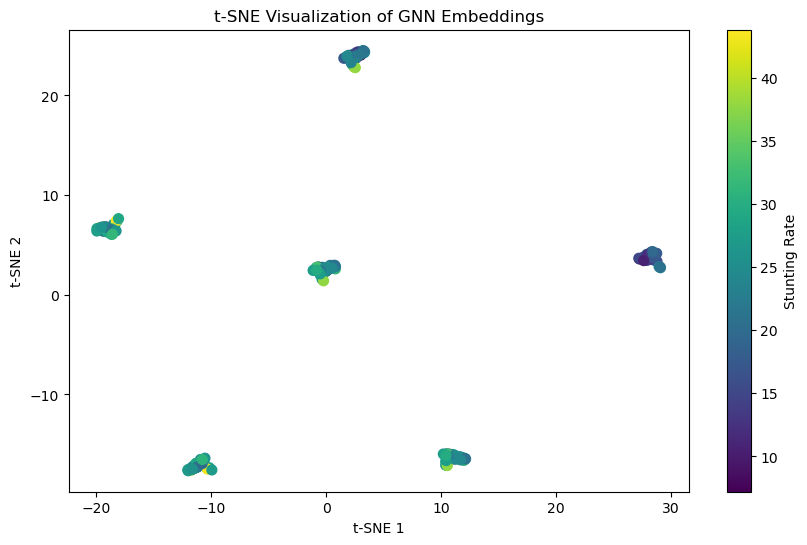

In [222]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Misal X adalah embedding dari GNN (204, 512)
X = x_gnn

# Jalankan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50)
plt.title("t-SNE Visualization of GNN Embeddings")
plt.colorbar(label='Stunting Rate')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()
